In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils.FinalUtils import load_ec_csv, create_voltage_schedule

In [ ]:
icp_df = pd.read_csv('..../data/ICP-MS/Example_processed_data_020525_before_25000.csv')

icp_df

In [ ]:
ec_df = load_ec_csv('..../data/EChem/Raw data_potential sqwave 0.4-0.95v_1h.csv')
ec_t = ec_df.index
ec_df

In [ ]:
from utils.FinalUtils import add_potential_to_dataframe

# I0 minimum starting time
# cycles how often to sample
# T is period

T = 3600 # in seconds

# v is list of voltages to cycler through
v = [0.4, 0.95]  # volts
cycles = 3


In [ ]:
tN = create_voltage_schedule(ec_t.min(), period=T, voltages=v, cycles=cycles)
applied_voltage_df = add_potential_to_dataframe(tN, ec_df.copy())


import matplotlib.pyplot as plt




fig, ax1 = plt.subplots(figsize=(16, 11), layout='constrained')

# Left Y-axis: µg/hr
ax1.set_xlabel('Time (min)')
ax1.set_ylabel(f' (µg/hr)', color='tab:red')
line1, = ax1.plot(t, y, color='tab:red', label=f'(µg/hr)')
ax1.tick_params(axis='y', labelcolor='tab:red')

plt.show()
plt.close()


In [ ]:
icp_df

In [ ]:
from utils.FinalUtils import load_trunc_icp_csv
# load_trunc_icp_csv(icp_df: pd.DataFrame, del_start: int, response_delay: int, t: str) -> pd.DataFrame
icp_df = load_trunc_icp_csv(icp_df, del_start=0, response_delay=0, t='Time')

In [ ]:
icp_df

# Specify the response index here
## 1 is the first response column, 2 is the second, etc.

In [ ]:
response_index = 1

In [ ]:
# set the response data
if not icp_df.columns.empty:
    cols_to_drop = []
    if 'Time' in icp_df.columns:
        cols_to_drop.append('Time')
    if 'Replicate' in icp_df.columns:
        cols_to_drop.append('Replicate')
    if 'Reading' in icp_df.columns:
        cols_to_drop.append('Reading')

    responses = icp_df.drop(columns=cols_to_drop)
    if responses.empty and not icp_df.empty: # Check if all columns were dropped, and df wasn't empty initially
        raise ValueError("All columns were identified as non-response columns. No response data left.")
else:
    raise ValueError("DataFrame has no columns.")

response = responses.columns[response_index-1]
response_data = icp_df[response]

In [ ]:
from utils.FinalUtils import interpolate
interp_df = interpolate(icp_trunc_df=icp_df, ec_df=ec_df)

# SPECIFY C and M from Regression Equation
# SPECIFY FLOW_RATE

In [ ]:
c = 0
m = 103054
FLOW_RATE = 0.403
AMOUNT_OF_ELEMENT = 1.176

In [ ]:
interp_df['Corrected_Time'] = (interp_df.index - (25 + 2730)) / 60

In [ ]:
final_df = interp_df.copy()
final_df[f'{response}-ppb'] = (final_df[response] - c)/m
final_df[f'{response}-ug/hr'] = final_df[f'{response}-ppb'] * 0.001 * 60 * FLOW_RATE
final_df[f'{response}-ug/hr/ug{response}'] = final_df[f'{response}-ug/hr'] / AMOUNT_OF_ELEMENT

# final_df.set_index('Time', inplace=True)
final_df.to_csv('..../output/ICPMS-EChem-Combined.csv')
final_df


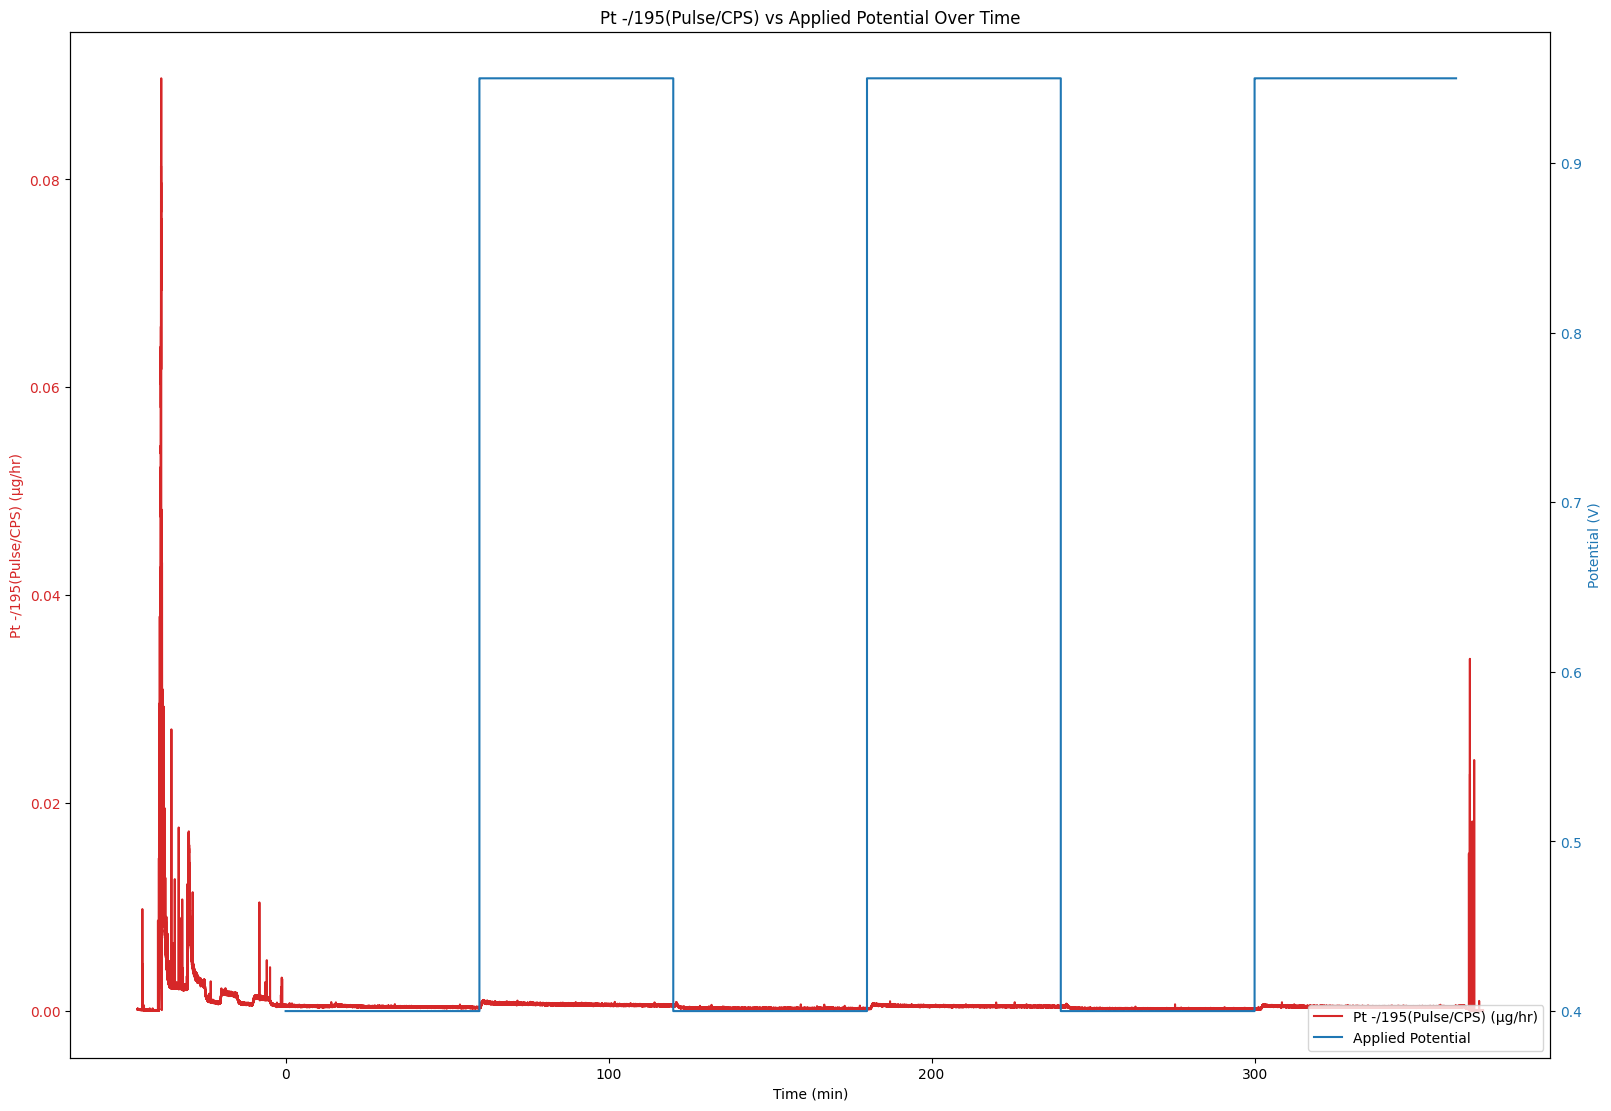

In [27]:
import matplotlib.pyplot as plt

# Extract matching values
t1 = final_df['Corrected_Time']
ec_t = applied_voltage_df.index / 60
y1 = final_df[f'{response}-ug/hr'].values
y2 = applied_voltage_df['Applied_Voltage (V)'].values

fig, ax1 = plt.subplots(figsize=(16, 11), layout='constrained')

# Left Y-axis: µg/hr
ax1.set_xlabel('Time (min)')
ax1.set_ylabel(f'{response} (µg/hr)', color='tab:red')
line1, = ax1.plot(t1, y1, color='tab:red', label=f'{response} (µg/hr)')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Right Y-axis: Applied Potential
ax2 = ax1.twinx()
ax2.set_ylabel('Potential (V)', color='tab:blue')
line2, = ax2.step(ec_t, y, color='tab:blue', label='Applied Potential', where='post')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Legend
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower right')

plt.title(f'{response} vs Applied Potential Over Time')
plt.show()
plt.close()
